In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
import pandas as pd

In [18]:
!pip install transformers

In [19]:
!pip install datasets

In [20]:
df=pd.read_csv('/content/drive/MyDrive/IT350/datasets/qqp/qqp.csv',names=['question1','question2','label'],header=None)
df["label"] = df["label"].astype(str).astype(int)
df

,question1,question2,label
0,How is Pulsar 220?,Is Pulsar 220 good?,1
1,How much marks one need to score in GATE to ge...,How much marks one need to score in GATE to ge...,0
2,How does GoldFlake get the smoothest cigarette...,What are the best cigarettes you can get at 7-11?,0
3,How I increase my focus in study?,How do we increase concentration?,1
4,I want to do biotechnology from abroad which c...,Why doesn’t Sterling Immigration update their ...,0
...,...,...,...
23432,"How do JavaScript frameworks like Node.js, Bac...",What are the going hourly contracting rates fo...,0
23433,Is there anything bigger than the universe?,"If the universe is ""all"" then is anything prev...",0
23434,What is the difference between scripting langu...,What's the difference between a programming la...,1
23435,What's your resolutions for 2017?,What are some meaningful new year resolutions ...,1


In [21]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25)
train.to_csv('/content/drive/MyDrive/IT350/datasets/qqp/train.csv',index=False)
test.to_csv('/content/drive/MyDrive/IT350/datasets/qqp/test.csv',index=False)

In [22]:
from datasets import load_dataset

In [23]:
raw_dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/IT350/datasets/qqp/train.csv',
                                              'test': '/content/drive/MyDrive/IT350/datasets/qqp/test.csv'})

Using custom data configuration default-fe2c0ea82d8a38a8


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fe2c0ea82d8a38a8/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 17577
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 5860
    })
})

In [25]:
df.dtypes

question1    object
question2    object
label         int64
dtype: object

In [26]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [27]:
raw_dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None)}

In [28]:
def tokenize_function(examples):
    return tokenizer(examples["question1"],examples["question2"], padding="max_length", truncation=True)


tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [29]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 17577
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5860
    })
})

In [30]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(20))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

In [31]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
tf_train_dataset = full_train_dataset.remove_columns(["question1","question2"]).with_format("tensorflow")
tf_eval_dataset = full_eval_dataset.remove_columns(["question1","question2"]).with_format("tensorflow")

In [33]:
train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(4)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["label"]))
eval_tf_dataset = eval_tf_dataset.batch(4)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

history=model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=3)
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save_pretrained('/content/drive/MyDrive/IT350/models/BERT_QQP')

# Recreate the exact same model purely from the file
#new_model = keras.models.load_model('path_to_my_model')
# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model('/content/drive/MyDrive/IT350/mqp_model')

Epoch 1/3
4395/4395 [==============================] - 2481s 559ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.6768 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.7445
Epoch 2/3
4395/4395 [==============================] - 2462s 560ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.7666 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.6275
Epoch 3/3
4395/4395 [==============================] - 2461s 560ms/step - loss: 0.6679 - sparse_categorical_accuracy: 0.6199 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.6276


In [35]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

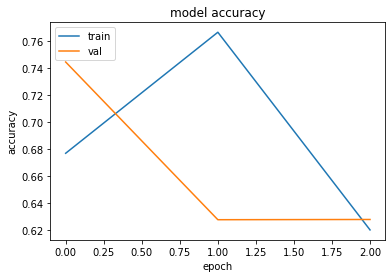

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()